In [1]:
import numpy as np
import random
import string
import torch
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [19]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

In [20]:
n = 30000
T = 10
k = 4

In [21]:
def generate_dict(k):

    letters = list(string.ascii_uppercase)
    assert k <= len(letters), "k ne doit pas dépasser 26"

    dico = {}
    embeddings = np.eye(k + 1, k+1, dtype=np.float32)
    # Ajout du token 'b' (begin)
    begin = embeddings[0]

    dico['b'] = begin
    char_to_id = {char: i for i, char in enumerate(letters)}
    id_to_char = {i: char for char, i in char_to_id.items()}

    # Ajout des k lettres
    for i in range(k):
        key = letters[i]
        dico[key] = embeddings[i + 1]

    return dico, char_to_id, id_to_char

In [22]:
dico, char_to_id, id_to_char = generate_dict(k)
dico

{'b': array([1., 0., 0., 0., 0.], dtype=float32),
 'A': array([0., 1., 0., 0., 0.], dtype=float32),
 'B': array([0., 0., 1., 0., 0.], dtype=float32),
 'C': array([0., 0., 0., 1., 0.], dtype=float32),
 'D': array([0., 0., 0., 0., 1.], dtype=float32)}

In [23]:
def generate_X_y(T, dico, n):
    """
    Génère n séquences (X, y) :
    - X est une séquence de T+1 lettres : 'b', ..., target (qui apparaît deux fois)
    - y est la lettre juste après la première apparition du target
    """
    assert 'b' in dico
    letters = [k for k in dico if k != 'b']
    assert len(letters) >= 2
    assert T >= 3, "T doit être au moins 3 pour que target puisse apparaître avant la fin et être suivi"

    X_list = []
    y_list = []

    for _ in range(n):
        seq = ['b']
        target = random.choice(letters)

        # Position du target dans le corps, garanti < T - 1
        insert_pos = random.randint(1, T - 2)

        middle_letters = []
        for i in range(1, T):
            if i == insert_pos:
                middle_letters.append(target)
            else:
                other_choices = [l for l in letters if l != target]
                middle_letters.append(random.choice(other_choices))

        seq.extend(middle_letters)
        seq.append(target)  # target en dernière position

        y = middle_letters[insert_pos]
        X_list.append(seq)
        y_list.append(y)

    return X_list, y_list


In [24]:
X, y = generate_X_y(T, dico, n)

In [25]:
X[0]

['b', 'C', 'D', 'B', 'A', 'B', 'D', 'B', 'D', 'B', 'A']

In [26]:
def create_tensordataset(X_list, y_list, dico):
    """
    Convertit X_list et y_list en TensorDataset.
    """
    X_tensor = torch.tensor([[dico[char] for char in seq] for seq in X_list], dtype=torch.float32)
    y_tensor = torch.tensor([char_to_id[y_char] for y_char in y_list], dtype=torch.long)

    return X_tensor, y_tensor

In [27]:
X, y = create_tensordataset(X, y, dico)

In [28]:
y[0]

tensor(1)

In [29]:
def token_accuracy(preds, targets):
    """
    Calcule l'accuracy lettre par lettre (token par token).
    """
    pred_classes = torch.argmax(preds, dim=-1)  # [B, T]
    correct = (pred_classes == targets).float()
    return correct.mean().item()

def train_model(model, train_loader, test_loader, epochs=10, lr=1e-3, device='cuda' if torch.cuda.is_available() else 'cpu'):
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()  # attente [B, C, T] vs [B, T]

    train_loss_list = []
    test_loss_list = []
    test_acc_list = []

    for epoch in range(1, epochs + 1):
        model.train()
        total_train_loss = 0

        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)  # xb: [B, T, D], yb: [B, T]
            preds = model(xb)                      # preds: [B, T, C]
    
      # -> [B, C, T] pour CrossEntropy

            loss = criterion(preds, yb)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss_list.append(loss.item())
            total_train_loss += loss.item()

        # 🔍 Validation à la fin de l'epoch
        model.eval()
        total_val_loss = 0
        total_acc = 0
        total_samples = 0
        with torch.no_grad():
            for xb, yb in test_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)

                val_loss = criterion(preds, yb)
                total_val_loss += val_loss.item()
                test_loss_list.append(val_loss.item())

                acc = token_accuracy(preds, yb)
                total_acc += acc * xb.size(0)
                total_samples += xb.size(0)

        avg_train_loss = total_train_loss / len(train_loader)
        avg_val_loss = total_val_loss / len(test_loader)
        avg_val_acc = total_acc / total_samples
        test_acc_list.append(avg_val_acc)

        print(f"Epoch {epoch}/{epochs} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Val Acc: {avg_val_acc:.4f}")

    return train_loss_list, test_loss_list, test_acc_list



In [30]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=100):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float32).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-torch.log(torch.tensor(10000.0)) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)  # [1, max_len, d_model]

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)].to(x.device)
        return x

In [31]:
class AttentionOnlyBlock(nn.Module):
    def __init__(self, d_model):
        super().__init__()
        self.Wq = nn.Linear(d_model, d_model, bias=False)
        self.Wk = nn.Linear(d_model, d_model, bias=False)
        self.Wv = nn.Linear(d_model, d_model, bias=False)
        self.norm = nn.LayerNorm(d_model)
        self.attn_weights = None  # <-- pour garder la dernière attention

    def forward(self, x):
        Q = self.Wq(x)
        K = self.Wk(x)
        V = self.Wv(x)
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / (Q.size(-1) ** 0.5)
        attn_weights = F.softmax(attn_scores, dim=-1)
        self.attn_weights = attn_weights.detach().cpu()  # stocker pour affichage

        attn_output = torch.matmul(attn_weights, V)
        return self.norm(attn_output + x)

class AttentionOnlyTransformer(nn.Module):
    def __init__(self, input_dim, num_classes, d_model=128, num_layers=2, max_len=100):
        super().__init__()
        self.embedding_proj = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_len)
        self.layers = nn.ModuleList([AttentionOnlyBlock(d_model) for _ in range(num_layers)])
        self.classifier = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding_proj(x)
        x = self.pos_encoder(x)
        for layer in self.layers:
            x = layer(x)
        x = x[:, -1, :]

        
        return self.classifier(x)

In [32]:
model = AttentionOnlyTransformer(input_dim=k+1, num_classes=k, d_model=256, num_layers=2, max_len=T+1)

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

# Création des DataLoaders
train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [35]:
train_loss_list, test_loss_list, test_acc_list = train_model(model, train_loader, test_loader, epochs=10, lr=0.001, device=device)

Epoch 1/10 | Train Loss: 1.0640 | Val Loss: 0.9382 | Val Acc: 0.5517
Epoch 2/10 | Train Loss: 0.8339 | Val Loss: 0.6863 | Val Acc: 0.7262
Epoch 3/10 | Train Loss: 0.1701 | Val Loss: 0.0003 | Val Acc: 1.0000
Epoch 4/10 | Train Loss: 0.0002 | Val Loss: 0.0001 | Val Acc: 1.0000


KeyboardInterrupt: 

In [36]:
debut = 0

In [37]:
def plot_attention_matrices_with_accuracy(model, sequences, char_to_id, special_char='A', special_value=7, device=device, n_layers=1):

    embeddings = np.eye(k)
    model.eval()

    num_sequences = len(sequences)
    fig, axs = plt.subplots(num_sequences, 2, figsize=(14, 3.5 * num_sequences))

    if num_sequences == 1:
        axs = [axs]

    for i, sequence in enumerate(sequences):
        # Embedding + entrée

        x_tensor = X_test[i][debut:].unsqueeze(0).to(device)  # [1, T+1, D]
        x_tensor = x_tensor.float()
        x_tensor = x_tensor.to(device)
        # Prédiction
        with torch.no_grad():
            preds = model(x_tensor).squeeze(0)  # [T, 1]
        end =T+1

        for k_layer in range(n_layers):
            attn = F.softmax(model.layers[k_layer].attn_weights, dim=-1).detach().squeeze(0).cpu().numpy()[:end,:end]
            sns.heatmap(attn, cmap="viridis", xticklabels=sequence[:end], yticklabels=sequence[:end], square=True,
                        cbar=True, ax=axs[i][k_layer])
            axs[i][k_layer].set_title(f"Layer {k_layer + 1} ")
            axs[i][k_layer].set_xlabel("Input Sequence")
            axs[i][k_layer].set_ylabel("Attention Weights")
            axs[i][k_layer].set_xticklabels(sequence[:end], rotation=45)
            axs[i][k_layer].set_yticklabels(sequence[:end], rotation=0)




    plt.tight_layout()
    plt.show()
    return fig

In [38]:
def decode_x_to_letters(x_tensor, id_to_char):
    """
    Convertit un tenseur [B, T, D] en liste de séquences de lettres.

    Args:
        x_tensor: tenseur de taille [B, T, D] (one-hot ou proche de one-hot)
        id_to_char: dictionnaire id -> lettre (ex: {0: 'A', 1: 'B', ...})

    Returns:
        List[str]: liste de chaînes de lettres, une par séquence du batch.
    """
    x_ids = torch.argmax(x_tensor, dim=-1).cpu().numpy() # [B, T]
     # Ajout du token 'b' (begin)
    sequences = []
    for row in x_ids:
        letters = [id_to_char[i] for i in row]
        sequences.append("".join(letters))
    return sequences


In [39]:
sequences = decode_x_to_letters(X_test[0:4,debut:], id_to_char)

In [40]:
s = sequences[0]
s


'ADCEBEDDDEC'

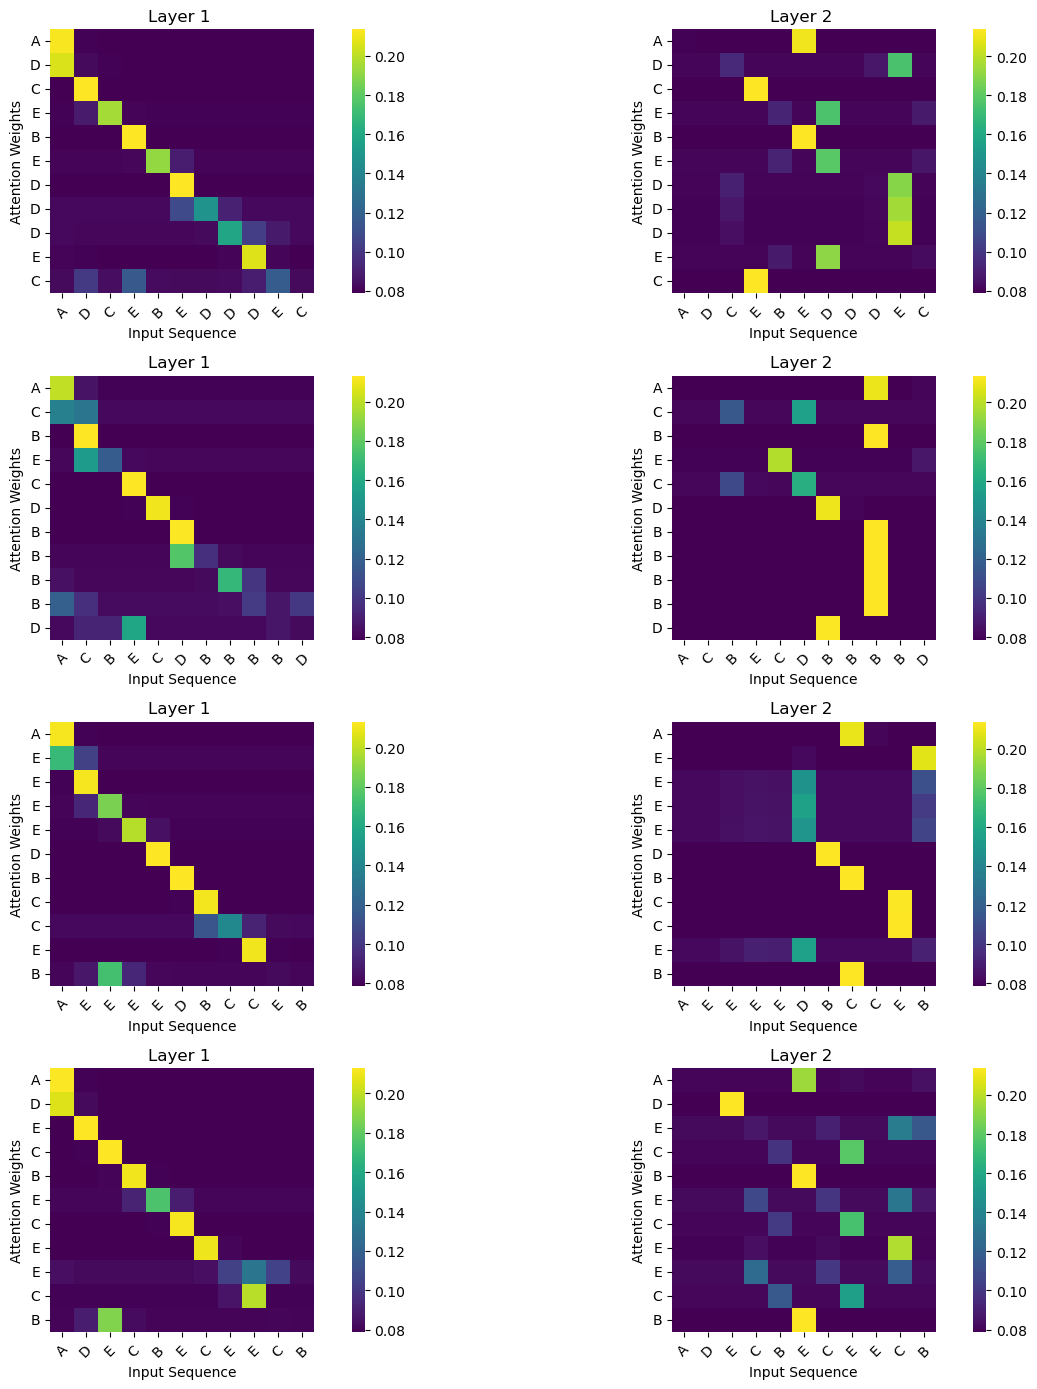

In [41]:
fig = plot_attention_matrices_with_accuracy(model, sequences, char_to_id, special_char='A', special_value=7, device=device, n_layers=2)